Code to impute ADC histogram values. For project titled: "Weekly Intra-Treatment Diffusion Weighted Imaging Dataset for Head and Neck Cancer Patients Undergoing MR-Linac Treatment". 

All PHI data (e.g., MRNs) have been removed from the notebook. 

For Fuller lab at MD Anderson Cancer Center. 

Last updated by Kareem Wahid on August 18, 2023.

In [1]:
import pandas as pd
import os
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

%config InlineBackend.figure_format = 'retina' # for high quality figure print outs

In [2]:
# read in data sheet that needs to be imputed (excel file not provided for Github due to contianed PHI)
df = pd.read_excel("Results.xlsx")

In [3]:
# harmonize names

df = df.replace('GTV_MBL', 'GTV_P_MBL', regex=True)
df = df.replace('GTV_P_BL', 'GTV_P_MBL', regex=True)
df = df.replace('GTV_BL', 'GTV_P_MBL', regex=True)

In [4]:
# now convert TPs to numbers

def f(row):
    if row['TPs'] == "preRT":
        val = 0
    elif row['TPs'] == "w1":
        val = 1
    elif row['TPs'] == "w2":
        val = 2
    elif row['TPs'] == "w3":
        val = 3
    elif row['TPs'] == "w4":
        val = 4
    elif row['TPs'] == "w5":
        val = 5
    elif row['TPs'] == "w6":
        val = 6
    elif row['TPs'] == "postRT":
        val = 7
    else:
        val = np.nan
    return val

df['TPs_number'] = df.apply(f, axis=1)

In [5]:
df.rename(columns={'path':'MRN'}, inplace=True)

In [6]:
df = df.drop(['folder', 'subfolder', 'TPs'], axis=1)

In [7]:
df = df.drop_duplicates(subset=['MRN', 'TPs_number', 'structure'], keep='first')

In [8]:
# convert to int so you can use later 
df['MRN'] = df['MRN'].astype(int)
df['TPs_number'] = df['TPs_number'].astype(int)

In [9]:
# add in column for imputation status (original, imputed)

df['imputation_status'] = 'original'

In [10]:
# create the nan columns/rows 

df_len = df.index[-1]+1

for index, row in df.iterrows():
    MRN = row['MRN']
    #print(MRN)
    structure = row['structure']
    #print(structure)
    tp_num = row['TPs_number']
    #print(tp_num)
    
    if structure == "GTV_P_MBL" or structure.endswith('_C') or structure.endswith('_S'):
        full_tps = list(range(0,8))
    else:
        full_tps = list(range(1,8))
        
    #print(full_tps)
    
    avaliable_tps = df[(df['MRN'] == MRN) & (df['structure'] == structure)]['TPs_number'].tolist()
    avaliable_tps = [int(tp) for tp in avaliable_tps] # convert to int so its consistent 
    #print(avaliable_tps)
    
    missing_tps = [tp for tp in full_tps if tp not in avaliable_tps]
    #print(missing_tps)
    
    # fille with na
    for tp in missing_tps:
        df.loc[df_len]=[np.nan for column in df.columns] 
        # fill with corresponding info
        df.loc[df_len, 'MRN'] = MRN
        df.loc[df_len, 'structure'] = structure
        df.loc[df_len, 'TPs_number'] = tp
        df.loc[df_len, 'imputation_status'] = 'imputed' # new 
    
        df_len+=1 


In [11]:
# interpolation happens here

df = df.sort_values(by = ['MRN', 'structure', 'TPs_number']) # sort to be descending to interpolation can work
df = df.set_index('TPs_number') # so interpolate can work properly..

# now can make call to dataframe and fill in imputing values in subselection 
for index, row in df.iterrows():
    MRN = row['MRN']
    #print(MRN)
    structure = row['structure']
    #print(structure)
    
    try:
        df[(df['MRN'] == MRN) & (df['structure'] == structure)] = df[(df['MRN'] == MRN) & (df['structure'] == structure)].interpolate(method="slinear", fill_value="extrapolate", limit_direction="both")
    except:
        continue # just skip things where it fails, i.e., only 1 datapoint so impossible to extrapolate.. 

In [12]:
# replace negative interpolated values with 0 as floor

num = df._get_numeric_data()
num[num < 0] = 0

In [13]:
# remove the TP from the index so its back to normal 
df = df.reset_index(level=0)

In [14]:
# map MRNs to anonymized key here for use in Dina Data Descriptor so we can upload to Github without issues

# Load the CSV file
df_ids = pd.read_csv('PatientIDs.csv')
df_ids['PatID_Old'] = df_ids['PatID_Old'].str.split('_').str[0]
df_ids.rename(columns={'PatID_New':'ID'}, inplace=True)
df_ids['ID'] = df_ids['ID'].astype('int64')
df_ids['PatID_Old'] = df_ids['PatID_Old'].astype(int)

# Merge the dataframes on the MRN column
df = pd.merge(df, df_ids, how='left', left_on='MRN', right_on='PatID_Old')
df['ID'] = df['ID'].astype(str).replace('\.0', '', regex=True) # convert to string so plot doesn't have trailing .0 

In [15]:
# sort by 'ID'
df = df.sort_values('ID')

C:\Users\kawahid\Anaconda3\lib\site-packages\seaborn\regression.py:592: UserWarning: sharex is deprecated from the `lmplot` function signature. Please update your code to pass it using `facet_kws`.
  warnings.warn(msg, UserWarning)
C:\Users\kawahid\Anaconda3\lib\site-packages\seaborn\regression.py:592: UserWarning: sharey is deprecated from the `lmplot` function signature. Please update your code to pass it using `facet_kws`.
  warnings.warn(msg, UserWarning)


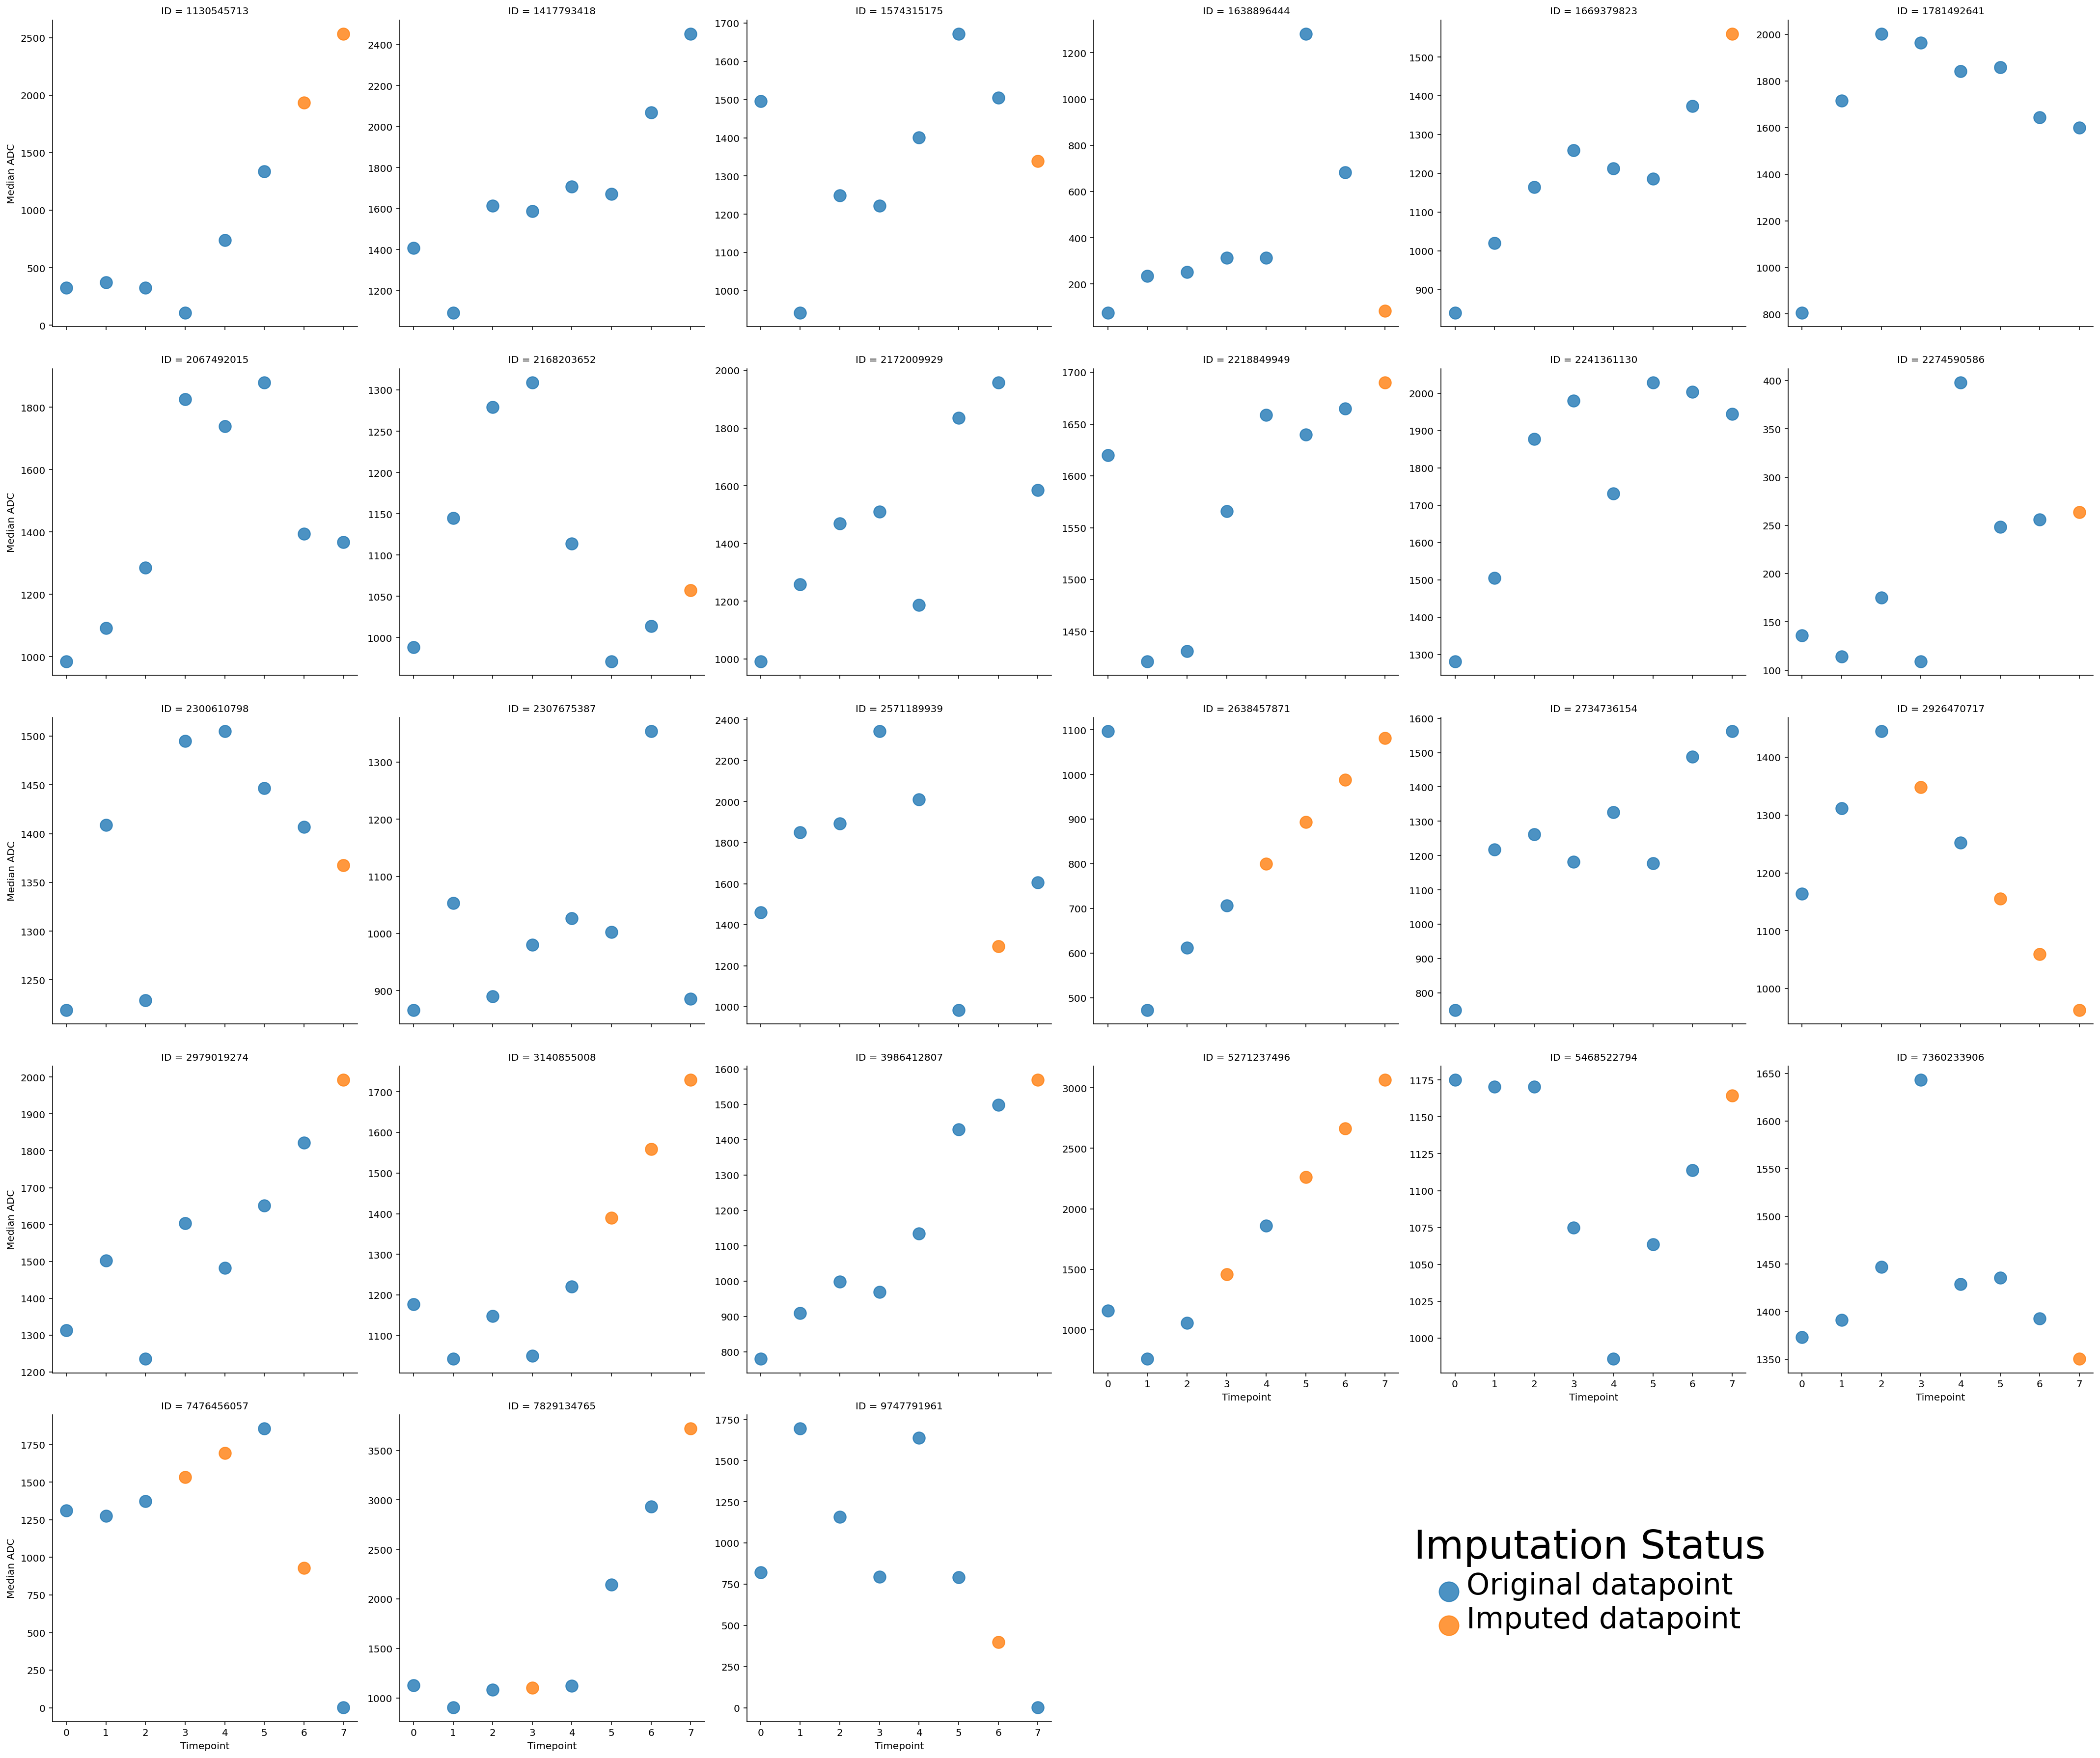

In [16]:
# plot out figure for data descriptor 

ax = sns.lmplot(data = df[df['structure'] == 'GTV_P_MBL'], x = "TPs_number", y = "Median", col= "ID", hue = "imputation_status", 
                col_wrap = 6, sharey=False, sharex=True,
               ci=None, aspect = 1,
               fit_reg=False, scatter_kws={'s': 150})

# Increase the size of the legend
ax._legend.set_title('Imputation Status')
plt.setp(ax._legend.get_texts(), fontsize='30') # for legend text
plt.setp(ax._legend.get_title(), fontsize='40') # for legend title

# Increase the size of the legend markers
ax._legend.legendHandles[0]._sizes = [400]
ax._legend.legendHandles[1]._sizes = [400]

# Get the legend
legend = ax._legend
# Change the legend labels
new_labels = ['Original datapoint', 'Imputed datapoint']
for t, l in zip(legend.texts, new_labels): t.set_text(l)

# Move the legend to the bottom right corner
ax._legend.set_bbox_to_anchor((0.8, 0.1))

# Set the axis labels
ax = ax.set_axis_labels('Timepoint', 'Median ADC')

#plt.savefig('ADC_median_over_time_imputed_anon_GTVPonly.pdf')


In [ ]:
# this is now an exact copy of Dinas "Results" with imputation (and slightly cleaner)

#df.to_csv("Results_interpolated_linear_spline.csv", index=False)

Generate deltas if needed.

In [ ]:
df_copy = df.copy()

In [ ]:
# dropna
df_copy = df_copy.dropna()

In [ ]:
# first melt  

df_copy_melt = pd.melt(df_copy, id_vars = ['TPs_number', "MRN", "structure"], var_name = "feature", value_name = "value") 

In [ ]:
%%time

df_len = df_copy_melt.index[-1]+1 

for index, row in df_copy_melt.iterrows():
    tp_num = row['TPs_number']
    #print(tp_num)
    MRN = row['MRN']
    #print(MRN)
    structure = row['structure']
    #print(structure)
    feature = row['feature']
    #print(feature)
    value = row['value']
    #print(value)
    
    next_tp = tp_num + 1
    #print(next_tp)
    
    if tp_num < 7:
        
        try: # will fail for things without 2 timepoints obv so skip that 

            next_tp_feature_value = df_copy_melt[(df_copy_melt['TPs_number'] == next_tp) & 
                                                 (df_copy_melt['MRN'] == MRN) & (df_copy_melt['structure'] == structure)
                                                & (df_copy_melt['feature'] == feature)]['value'].values[0]

            print(next_tp_feature_value)
            
            if value == next_tp_feature_value or value == 0: # account for divide by 0
                delta_feature_value = 0
            else:
                delta_feature_value = ((next_tp_feature_value - value)/value)*100

            print(delta_feature_value)

            # fill with corresponding info
            df_copy_melt.loc[df_len, 'TPs_number'] = next_tp
            df_copy_melt.loc[df_len, 'MRN'] = MRN
            df_copy_melt.loc[df_len, 'structure'] = structure
            df_copy_melt.loc[df_len, 'feature'] = "delta_" + feature
            df_copy_melt.loc[df_len, 'value'] = delta_feature_value

            df_len+=1 
            
        except:
            continue


In [ ]:
# sort back in familiar way 

df_copy_melt_sorted = df_copy_melt.sort_values(by = ['MRN', 'structure', 'feature', 'TPs_number'])

In [ ]:
df_copy_melt_sorted['MRN'] = df_copy_melt_sorted['MRN'].astype(int)
df_copy_melt_sorted['TPs_number'] = df_copy_melt_sorted['TPs_number'].astype(int)

Transform into pivot version 

In [ ]:
%%time

df_new = pd.DataFrame(columns=['MRN']) # make dataframe
counter = -1 

MRN_list = df_copy_melt_sorted['MRN'].unique().tolist()

for MRN in MRN_list:
    #print(MRN)
    counter+=1
    df_new.loc[counter, 'MRN'] = MRN # this shold always work.. 

    for index, row in df_copy_melt_sorted[df_copy_melt_sorted['MRN'] == MRN].iterrows():
        tp_num = row['TPs_number']
        #print(tp_num)
        MRN = row['MRN']
        #print(MRN)
        structure = row['structure']
        #print(structure)
        feature = row['feature']
        #print(feature)
        value = row['value']
        #print(value)

        new_column_name = 'week'+ str(tp_num)+'_'+structure+'_'+feature 
    
        try:
            df_new.loc[counter, new_column_name] = value
            
        except Exception as e:
            #print("something wrong", e)
            df_new.loc[counter, new_column_name] = np.nan


In [ ]:
# final

#df_new.to_csv("Dataset_interpolated_linear_spline.csv", index=False)